# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

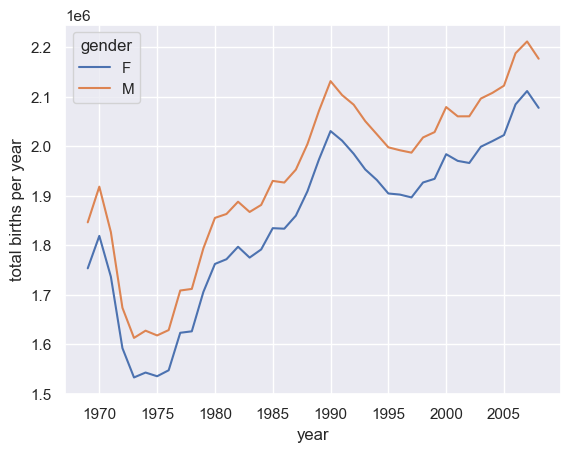

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt 

#seaborn background
sns.set_theme()
df=pd.read_csv('data/births.csv')
f=df.groupby(['year','gender']).sum()
f.births

fig, ax = plt.subplots()
sns.lineplot(
    hue="gender",
    data=f,
    x='year',
    y="births",
    )

ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.set_ylabel('total births per year')
plt.show()

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

In [137]:
#source
#  https://www.abs.gov.au/websitedbs/d3310114.nsf/home/time+series+analysis:+the+basics
#https://dziganto.github.io/python/time%20series/Introduction-to-Time-Series/#:~:text=Seasonality%20is%20a%20periodic%20component,them%20as%20a%20noise%20component.

# The residual components are the noise. they are random fluctuations in the data

# the periodic component is the seasonality. They are cycles that repeat regularly over time

# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

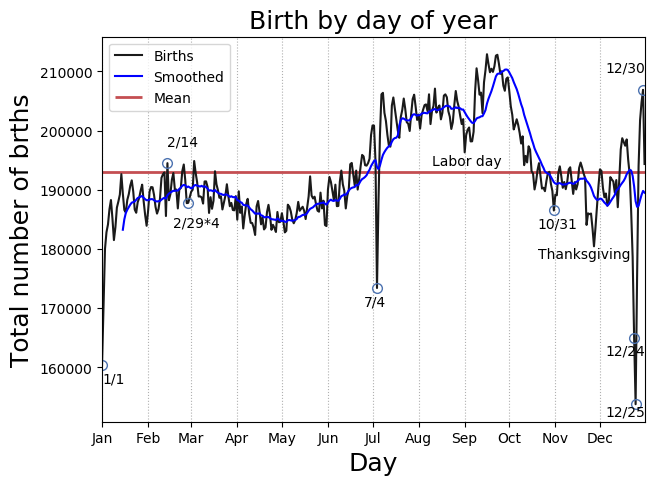

In [138]:
plt.style.use('default')
df=pd.read_csv('data/births.csv')



df=df.dropna()
df=df.loc[df.day<=31]
df.day=df.day.astype(int)
a=df.groupby(['month','day']).sum()
a=a.drop(columns='year')
a=a.loc[a.births>50000]
a.index = [pd.datetime(2020, month, day)
                        for (month, day) in a.index]
b=a.rolling(15).mean()

mean=a.births.mean()






fig, ax = plt.subplots(figsize=(7,5))

ax.plot(a.index,a.births,color='k',label='Births')
ax.plot(b,color='blue',label='Smoothed')
ax.hlines(y=mean, xmin=a.iloc[0].name, xmax=a.iloc[-1].name,
linewidth=2, color='r', label ='Mean')
ax.legend(loc='upper left')
ax.set_ylabel('Total number of brths',fontsize=18)
ax.set_xlabel('Day',fontsize=18)
ax.set_title('Birth by day of year',fontsize=18)
ax.set_xlim(a.iloc[0].name,a.iloc[-1].name)
ax.xaxis.grid(linestyle=':') # horizontal lines

dateList=[(7,4),(2,14),(1,1),(2,28),(10,31),(12,30),(12,24),(12,25)]
for m,d in dateList:
    ax.plot(a.loc[a.index==pd.datetime(2020, m, d)],'ob', mfc='none',Markersize=7)



#can be done in a loop 
ax.text(pd.datetime(2020, 6, 25),
a.loc[a.index==pd.datetime(2020, 7, 4)].values-3000,
'7/4',fontsize=10)

ax.text(pd.datetime(2020, 1, 1),
a.loc[a.index==pd.datetime(2020, 1, 1)].values-3000,
'1/1',fontsize=10)


ax.text(pd.datetime(2020, 2, 14),
a.loc[a.index==pd.datetime(2020, 2, 14)].values+3000,
'2/14',fontsize=10)

ax.text(pd.datetime(2020, 2, 18),
a.loc[a.index==pd.datetime(2020, 2, 28)].values-4000,
'2/29*4',fontsize=10)

ax.text(pd.datetime(2020, 10, 20),
a.loc[a.index==pd.datetime(2020, 10, 31)].values-3000,
'10/31',fontsize=10)

ax.text(pd.datetime(2020, 12, 5),
a.loc[a.index==pd.datetime(2020, 12, 30)].values+3000,
'12/30',fontsize=10)

ax.text(pd.datetime(2020, 12, 5),
a.loc[a.index==pd.datetime(2020, 12, 24)].values-3000,
'12/24',fontsize=10)

ax.text(pd.datetime(2020, 12, 5),
a.loc[a.index==pd.datetime(2020, 12, 25)].values-2000,
'12/25',fontsize=10)

ax.text(pd.datetime(2020, 8, 10),
a.loc[a.index==pd.datetime(2020, 9, 5)].values-4000,
'Labor day ',fontsize=10)


ax.text(pd.datetime(2020,10 , 20),
a.loc[a.index==pd.datetime(2020, 11, 26)].values-5000,
'Thanksgiving ',fontsize=10)



month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
#changing the xticks
ax.set_xticklabels(month)


plt.show()

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [139]:
import gzip
import numpy as np
import pandas as pd


# read the entire file into a Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)



In [140]:
#2.1
a=recipes.description.str.contains('breakfast')
N=a.sum()
print(F'There are {N} breakfast food recipes' )

There are 3442 breakfast food recipes


In [141]:
L=["parsley", "paprika", "tarragon"]

def recommend_ingredients(L, df):
    for e in L:
        df[e]=df.ingredients.str.contains(e)
        #if no recipe contain one of the ingredient 
        if df[e].sum()==0:
            return None
    ids=(df.loc[df[L]
        #Return True if all elements are True.
        .all(axis=1)==True]
        .ingredients
        .index
        )
    if len(ids)==0:
        return 'no recipes'
    else:
        return list(ids)


ids=recommend_ingredients(L,recipes)

print(ids)

[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]


# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together

In [142]:
import json
movies_url = {
"movies_metadata": "1RLvh6rhzYiDDjPaudDgyS9LmqjbKH-wh",
"keywords": "1YLOIxb-EPC_7QpkmRqkq9E6j7iqmoEh3",
"ratings": "1_5HNurSOMnU0JIcXBJ5mv1NaXCx9oCVG",
"credits": "1bX9othXfLu5NZbVZtIPGV5Hbn8b5URPf",
"ratings_small": "1fCWT69efrj4Oxdm8ZNoTeSahCOy6_u6w",
"links_small": "1fh6pS7XuNgnZk2J3EmYk_9jO_Au_6C15",
"links": "1hWUSMo_GwkfmhehKqs8Rs6mWIauklkbP",
}

def read_gdrive(url):
    """
    Reads file from Google Drive sharing link
    """
    path = 'https://drive.google.com/uc?export=download&id='+url
    return pd.read_csv(path)

# 3. Movies!
df1 = read_gdrive(movies_url["movies_metadata"])
df10 = read_gdrive(movies_url["ratings"])

#hint we have to use eval 
#best way to read each rows 
df2=pd.read_csv('data/credits.csv')


In [143]:
#name list 
v=[]
#movie id list
id_array=[]
a=(df2.crew)

for i in range(len(a)):
    if len(a[i])>500:
        df = pd.DataFrame.from_dict(eval(a[i]), orient='columns')
        df3=df.loc[df['job']=='Director']
        id_array.append(df2.id[i])
        v.append(df3.name.values)

df4=pd.DataFrame()
df4['Director_name']=v
df4['id']=id_array
df4.id=df4.id.astype(str)

In [144]:
df5=pd.merge(df1,df4)
df5=df5[['id','title','Director_name','vote_average','vote_count']]
df5.Director_name=df5.Director_name.astype(str)
df5.Director_name=(df5.Director_name
.str.replace("[", "")
.str.replace("]", "")
.str.replace("'", "")
.str.replace('"', ""))

df6=df5.groupby('Director_name').agg({'vote_average':'mean','vote_count':'sum'})
#numer of total vote count that the director need 
#to have to be part of the list 
N=10000
df6=df6.loc[df6.vote_count>N]
top_20=df6.nlargest(10,'vote_average')
top_20

,vote_average,vote_count
Director_name,,
Pete Docter,7.733333,19935.0
Hayao Miyazaki,7.700000,14700.0
Christopher Nolan,7.533333,67449.0
Quentin Tarantino,7.490000,45910.0
Joss Whedon,7.400000,20548.0
Tim Miller,7.400000,11444.0
Wes Anderson,7.370000,11743.0
David Fincher,7.350000,37588.0
Alejandro González Iñárritu,7.250000,14077.0


In [145]:
display(df5.loc[df5.Director_name==top_20.index[0]])
display(df5.loc[df5.Director_name==top_20.index[1]])
display(df5.loc[df5.Director_name==top_20.index[2]])
display(df5.loc[df5.Director_name==top_20.index[3]])
display(df5.loc[df5.Director_name==top_20.index[4]])

,id,title,Director_name,vote_average,vote_count
4003,585,"Monsters, Inc.",Pete Docter,7.5,6150.0
11398,14160,Up,Pete Docter,7.8,7048.0
22734,150540,Inside Out,Pete Docter,7.9,6737.0


,id,title,Director_name,vote_average,vote_count
2437,128,Princess Mononoke,Hayao Miyazaki,8.2,2041.0
4614,129,Spirited Away,Hayao Miyazaki,8.3,3968.0
4899,8392,My Neighbor Totoro,Hayao Miyazaki,8.0,1730.0
5205,10515,Castle in the Sky,Hayao Miyazaki,7.8,877.0
5827,81,Nausicaä of the Valley of the Wind,Hayao Miyazaki,7.7,808.0
6438,15371,Lupin the Third: The Castle of Cagliostro,Hayao Miyazaki,7.5,170.0
7540,16859,Kiki's Delivery Service,Hayao Miyazaki,7.6,768.0
7605,11621,Porco Rosso,Hayao Miyazaki,7.6,563.0
8129,4935,Howl's Moving Castle,Hayao Miyazaki,8.2,2049.0
11056,12429,Ponyo,Hayao Miyazaki,7.5,953.0


,id,title,Director_name,vote_average,vote_count
2073,11660,Following,Christopher Nolan,7.2,363.0
3447,77,Memento,Christopher Nolan,8.1,4168.0
4430,320,Insomnia,Christopher Nolan,6.8,1181.0
8480,272,Batman Begins,Christopher Nolan,7.5,7511.0
9505,1124,The Prestige,Christopher Nolan,8.0,4510.0
10439,155,The Dark Knight,Christopher Nolan,8.3,12269.0
12697,27205,Inception,Christopher Nolan,8.1,14075.0
14684,49026,The Dark Knight Rises,Christopher Nolan,7.6,9263.0
17767,157336,Interstellar,Christopher Nolan,8.1,11187.0
19828,43629,Doodlebug,Christopher Nolan,6.6,105.0


,id,title,Director_name,vote_average,vote_count
251,680,Pulp Fiction,Quentin Tarantino,8.3,8670.0
886,500,Reservoir Dogs,Quentin Tarantino,8.1,3821.0
1368,184,Jackie Brown,Quentin Tarantino,7.3,1580.0
5633,24,Kill Bill: Vol. 1,Quentin Tarantino,7.7,5091.0
6093,393,Kill Bill: Vol. 2,Quentin Tarantino,7.7,4061.0
9952,1991,Death Proof,Quentin Tarantino,6.7,1359.0
11312,16869,Inglourious Basterds,Quentin Tarantino,7.9,6598.0
15923,68718,Django Unchained,Quentin Tarantino,7.8,10297.0
21348,273248,The Hateful Eight,Quentin Tarantino,7.6,4405.0
29232,10614,My Best Friend's Birthday,Quentin Tarantino,5.8,28.0


,id,title,Director_name,vote_average,vote_count
8575,16320,Serenity,Joss Whedon,7.4,1287.0
11219,14301,Dr. Horrible's Sing-Along Blog,Joss Whedon,7.8,236.0
14371,24428,The Avengers,Joss Whedon,7.4,12000.0
16574,91739,Much Ado About Nothing,Joss Whedon,7.1,117.0
20293,99861,Avengers: Age of Ultron,Joss Whedon,7.3,6908.0


In [146]:
#my answer depends on the total number of vote counts, but if the total vote count is 
#N=10000

print(F'For a total vote count >{N}, the best director is {top_20.index[0]}')

For a total vote count >10000, the best director is Pete Docter
